In [22]:
# Importing required Libraries

import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# For model building we used these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
# We will see the correlation between each feature
import seaborn as sns

In [10]:
# Reading the dataset

path = "./BTC-USD.csv"
df = pd.read_csv(path)

# Understanding Data

In [11]:
print('Dataset Shape:', df.shape)

Dataset Shape: (3288, 7)


In [12]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [13]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3283,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
3284,2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055
3285,2023-12-30,42091.753906,42584.125000,41556.226563,42156.902344,42156.902344,16013925945
3286,2023-12-31,42152.097656,42860.937500,41998.253906,42265.187500,42265.187500,16397498810
3287,2024-01-01,42280.234375,42831.003906,42227.503906,42817.222656,42817.222656,15160324096


In [14]:
print('Data Info:', df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3288 non-null   object 
 1   Open       3288 non-null   float64
 2   High       3288 non-null   float64
 3   Low        3288 non-null   float64
 4   Close      3288 non-null   float64
 5   Adj Close  3288 non-null   float64
 6   Volume     3288 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 179.9+ KB
Data Info: None


In [15]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3.288000e+03
mean,15038.515537,15389.980094,14660.348897,15050.073186,15050.073186,1.708131e+10
std,16244.777395,16634.536688,15807.953069,16246.954922,16246.954922,1.915119e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,7.860650e+06
25%,1186.287537,1206.827515,1172.422485,1187.855011,1187.855011,3.361940e+08
50%,8660.375976,8831.566894,8392.174805,8660.093750,8660.093750,1.278290e+10
75%,25264.314453,25957.333008,24909.188477,25620.604980,25620.604980,2.741347e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


# Exploratory Data Analysis

In [16]:
# We adjust the Date Format to be all the same Year-Month-Day
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# We set the Date to be the Index
df.set_index('Date', inplace=True)

In [17]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800
...,...,...,...,...,...,...
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055
2023-12-30,42091.753906,42584.125000,41556.226563,42156.902344,42156.902344,16013925945


In [18]:
# here we just resample the dataset based on daily monthly yearly frequency

# Resampling to Daily frequency
df_day = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

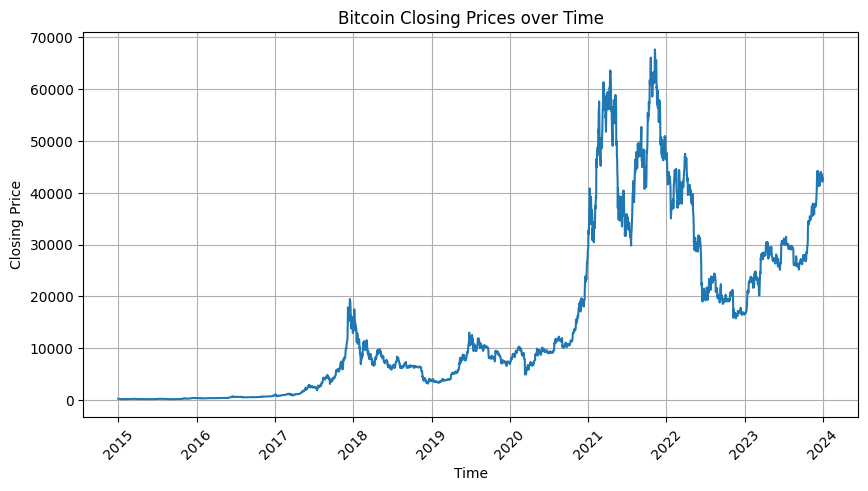

In [19]:
# Plot 1: Line chart of Bitcoin closing prices over time
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'])
plt.title('Bitcoin Closing Prices over Time')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

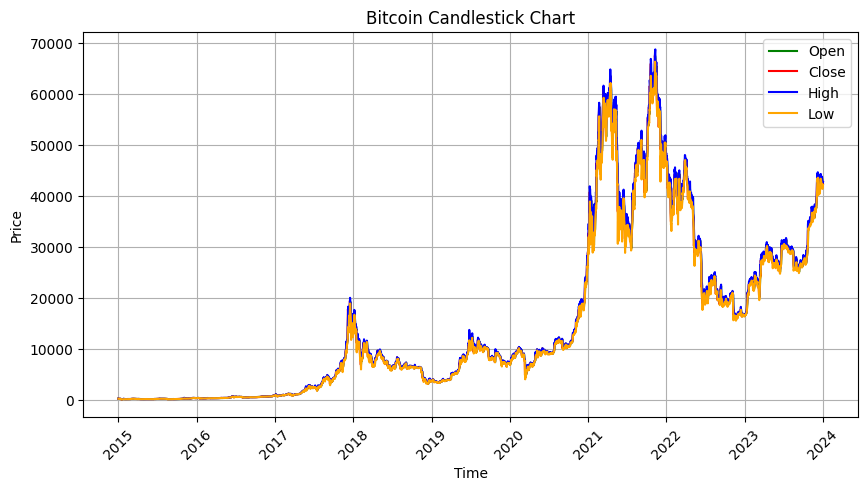

In [20]:
# Plot 2: Candlestick chart of Bitcoin prices
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Open'], color='green', label='Open')
plt.plot(df.index, df['Close'], color='red', label='Close')
plt.plot(df.index, df['High'], color='blue', label='High')
plt.plot(df.index, df['Low'], color='orange', label='Low')
plt.title('Bitcoin Candlestick Chart')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

* Nothing is clear
* The value remains close for all the variables
* There is a huge increase in all the prices in 2018 and 2021 with 2018 peak to be lower than 2021.

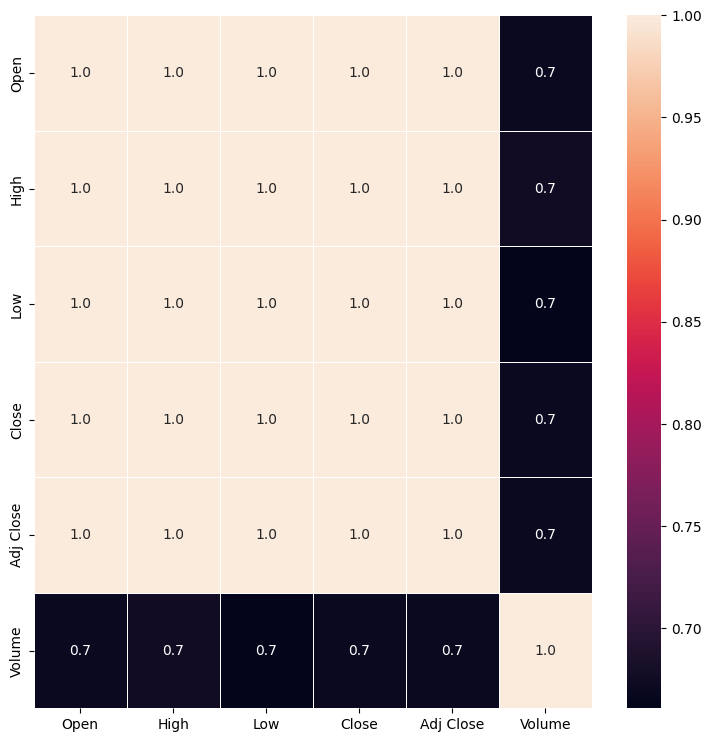

In [23]:
f,ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

* Open, High, Low, Close, and Adj Close: These variables represent the opening, highest, lowest, closing, and adjusted closing prices of Bitcoin for each day. They have a perfect positive correlation of 1.0 with each other, meaning they move in the same direction and by the same amount. This makes sense because the prices of Bitcoin are determined by the market demand and supply, which are reflected in these variables.

* Volume: This variable represents the number of Bitcoins traded for each day. It has a moderate positive correlation of 0.7 with the other variables, meaning it tends to move in the same direction but not by the same amount. This indicates that there is some relationship between the trading volume and the price movements of Bitcoin, but it is not very strong or consistent. There may be other factors that affect the volume, such as news, events, or sentiment.

# LSTM Model

## * First Step is Preparing Data for Training and Testing.

* Here we are just considering 1 year data for training data.

* Since Bitcoin price has drastically flucated from 200 dollar in year 2015 to 15000 dollar in year 2018 to 3000 dollar in year 2019(theses values are apporx) so we will just consider 2 Year to avoid this type of flucation in the data.

* As we want to predict Close Price of the Bitcoin so we are just Considering Close and Date.

In [24]:
# Lets First Take all the Close Price 
closedf = df.reset_index()[['Date', 'Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (3288, 2)


In [25]:
# Resampling the closedf based on daily and monthly

# Resampling to Daily frequency
dfclose_day = df.groupby(['Date']).mean(['Close']).reset_index()

dfclose_day['Date'] = pd.to_datetime(dfclose_day['Date'])
dfclose_day.set_index(['Date'], inplace=True)
dfclose_day = dfclose_day[['Close']]

# Resampling to monthly frequency
dfclose_month = dfclose_day.resample('M').mean(['Close'])


In [26]:
# prediction for 100 days
pred_days = 365
train = dfclose_day[:len(dfclose_day)-pred_days]
test = dfclose_day[len(dfclose_day)-pred_days:]
train.shape,test.shape

((2923, 1), (365, 1))

In [27]:
training_set = train.values
training_set.shape

(2923, 1)

In [28]:
# create train and val
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
X_train = training_set[0:(len(training_set)-1)]
y_train = training_set[1:]
#need to be 3D
X_train = np.reshape(X_train, (len(X_train), 1, 1))
X_train.shape

(2922, 1, 1)

In [29]:
#build model
model = Sequential()
model.add(LSTM(128,activation='relu',input_shape=(1,1),return_sequences=True))
model.add(Dense(32))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [30]:
history = model.fit(X_train,y_train,epochs=50)

Epoch 1/50
92/92 [==============================] - 1s 805us/step - loss: 0.0297
Epoch 2/50
92/92 [==============================] - 0s 844us/step - loss: 6.8126e-04
Epoch 3/50
92/92 [==============================] - 0s 832us/step - loss: 6.1204e-04
Epoch 4/50
92/92 [==============================] - 0s 841us/step - loss: 5.8699e-04
Epoch 5/50
92/92 [==============================] - 0s 832us/step - loss: 5.3698e-04
Epoch 6/50
92/92 [==============================] - 0s 830us/step - loss: 5.9394e-04
Epoch 7/50
92/92 [==============================] - 0s 839us/step - loss: 5.3331e-04
Epoch 8/50
92/92 [==============================] - 0s 826us/step - loss: 5.4422e-04
Epoch 9/50
92/92 [==============================] - 0s 838us/step - loss: 5.4080e-04
Epoch 10/50
92/92 [==============================] - 0s 833us/step - loss: 5.1462e-04
Epoch 11/50
92/92 [==============================] - 0s 861us/step - loss: 4.9484e-04
Epoch 12/50
92/92 [==============================] - 0s 897us/step 

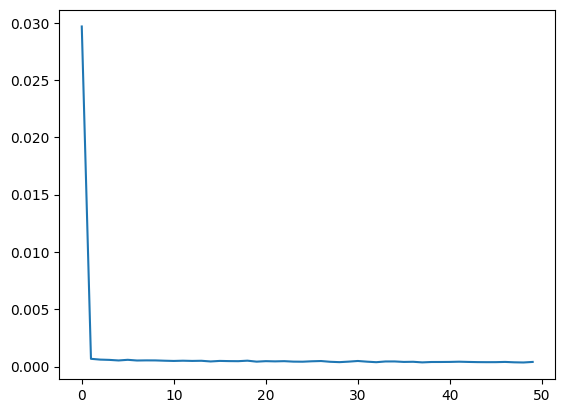

In [31]:
plt.plot(history.history['loss'],label='train_loss')

The graph shows that the model learned quickly from the data and reduced the loss, which is the difference between the model’s predictions and the actual targets. However, after a few epochs, the model stopped improving and the loss remained almost constant. This means that the model either reached its optimal performance or overfitted the data.

In [32]:
#prediction
test_set = test.values
test_set = scaler.transform(test_set)
test_set = np.reshape(test_set,(len(test_set),1,1))
pred = model.predict(test_set)
pred = np.reshape(pred,(len(test_set),1))
pred = list(scaler.inverse_transform(pred))
pred =pd.Series(pred,index=test.index)

12/12 [==============================] - 0s 580us/step


Text(0.5, 0, 'Date')

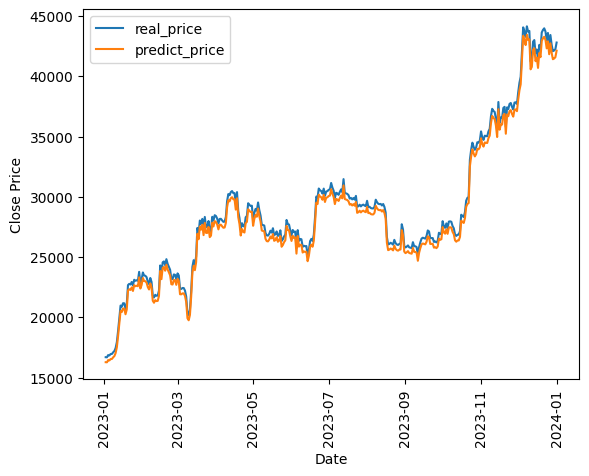

In [33]:
fig,ax = plt.subplots()
line1, = ax.plot(test,label='real_price')
line2, = ax.plot(pred,label='predict_price')
ax.legend(handles=[line1, line2],loc='upper left')
plt.xticks(rotation='vertical')
plt.ylabel('Close Price')
plt.xlabel('Date')

In [35]:
def predict_stock_prices_for_years(model, scaler, df, target_year):
    # Filter the dataframe for years up to the target year
    df_years = df[df.index.year <= target_year]

    # Extract the Close prices
    df_close_years = df_years[['Close']]

    # Use the same scaler used for training data
    test_set = scaler.transform(df_close_years.values)
    test_set = np.reshape(test_set, (len(test_set), 1, 1))

    # Make predictions
    pred = model.predict(test_set)
    pred = np.reshape(pred, (len(test_set), 1))
    pred = list(scaler.inverse_transform(pred))
    pred = pd.Series(pred, index=df_close_years.index)

    # Plot the results
    fig, ax = plt.subplots()
    for year in range(df_years.index.year.min(), target_year + 1):
        year_data = df_close_years[df_close_years.index.year == year]
        pred_data = pred[pred.index.year == year]
        line1, = ax.plot(year_data.index, year_data['Close'], label=f'Real Price {year}')
        line2, = ax.plot(pred_data.index, pred_data, label=f'Predicted Price {year}')

    ax.legend(loc='upper left')
    plt.xticks(rotation='vertical')
    plt.ylabel('Close Price')
    plt.xlabel('Date')
    plt.title(f'Stock Price Prediction up to {target_year}')

    plt.show()

103/103 [==============================] - 0s 460us/step


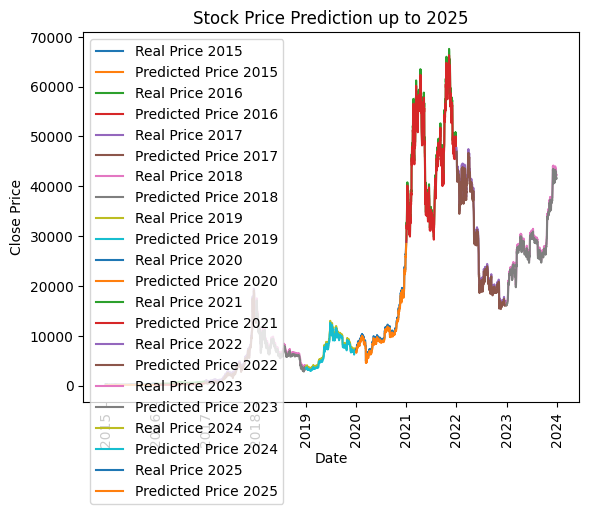

In [36]:
target_year = 2025

# Use the function to make predictions
predict_stock_prices_for_years(model, scaler, dfclose_day, target_year)